# **Data** Preprocessing

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import f1_score, classification_report, confusion_matrix
from joblib import load, dump

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

# **Model Implementation**

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:

from khmernltk import word_tokenize
from nltk.corpus import stopwords
english_stopwords = set(stopwords.words('english'))

In [5]:
print(f"Loaded {len(english_stopwords)} English stopwords from NLTK")
print("Preview:", sorted(list(english_stopwords))[:20])

Loaded 198 English stopwords from NLTK
Preview: ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been']


In [6]:
def clean_khmer_text(text):
    if not isinstance(text, str):
        return ""

    # 1. Remove html tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # 2. Remove zero-width characters
    text = re.sub(r'[\u200B-\u200D\uFEFF]', '', text)

    # 3. Remove punctuation (Latin + Khmer)
    text = re.sub(r'[!"#$%&\'()*+,—./:;<=>?@[\]^_`{|}~។៕៖ៗ៘៙៚៛«»-]', '', text)

    # 4. Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def khmer_tokenize(text):
    cleaned = clean_khmer_text(text)
    if not cleaned:
        return ""

    tokens = word_tokenize(cleaned)

    processed_tokens = []
    for token in tokens:
        # Pure English token (letters/numbers only)?
        if re.match(r'^[a-zA-Z0-9]+$', token):
            token_lower = token.lower()
            # Remove if it's an NLTK English stopword
            if token_lower in english_stopwords:
                continue
            processed_tokens.append(token_lower)  # Lowercase content English words
        else:
            # Keep Khmer or mixed tokens as-is
            processed_tokens.append(token)

    return " ".join(processed_tokens)

In [7]:
train_df = pd.read_csv('../data/processed/train_tokenized.csv', encoding='utf-8-sig')
val_df   = pd.read_csv('../data/processed/val_tokenized.csv', encoding=' utf-8-sig')
test_df  = pd.read_csv('../data/processed/test_tokenized.csv', encoding='utf-8-sig')

In [8]:
print(f"  - train_tokenized.csv ({len(train_df)} samples)")
print(f"  - val_tokenized.csv ({len(val_df)} samples)")
print(f"  - test_tokenized.csv ({len(test_df)} samples)")

  - train_tokenized.csv (5427 samples)
  - val_tokenized.csv (677 samples)
  - test_tokenized.csv (678 samples)


In [9]:
label_cols = ['culture', 'economic', 'education', 'environment', 
                 'health', 'politics', 'right', 'science']

X_train_text = train_df['text_tokenized']
y_train = train_df[label_cols]

X_val_text = val_df['text_tokenized']
y_val = val_df[label_cols]

X_test_text = test_df['text_tokenized']
y_test = test_df[label_cols]

# **TF-IDF Vectorization + TruncatedSVD**

In [10]:
tfidf = TfidfVectorizer(
    lowercase=False,          # Khmer has no case
    max_features=8000,
    min_df=3,
    max_df=0.85,
    ngram_range=(1, 2),
    analyzer=str.split        # Use str.split as text is pre-tokenized
)

X_train_tfidf = tfidf.fit_transform(train_df['text_tokenized'])
X_val_tfidf   = tfidf.transform(val_df['text_tokenized'])
X_test_tfidf  = tfidf.transform(test_df['text_tokenized'])

print(f"Vocabulary size: {len(tfidf.vocabulary_):,}")
print(f"TF-IDF shape (train): {X_train_tfidf.shape}")
print(f"TF-IDF shape (val): {X_val_tfidf.shape}")
print(f"TF-IDF shape (test): {X_test_tfidf.shape}")

Vocabulary size: 8,000
TF-IDF shape (train): (5427, 8000)
TF-IDF shape (val): (677, 8000)
TF-IDF shape (test): (678, 8000)


In [11]:
feature_names = np.array(tfidf.get_feature_names_out())
label_columns = ['culture', 'economic', 'education', 'environment',
                 'health', 'politics', 'right', 'science']

top_n = 10

print("="*80)
print("TOP 10 DISCRIMINATIVE TF-IDF TERMS PER CATEGORY")
print("="*80)

for label in label_columns:
    pos_mask = (y_train.iloc[:, label_columns.index(label)] == 1).values
    pos_count = pos_mask.sum()

    if pos_count == 0:
        print(f"\n{label.upper():<12} : No positive samples")
        continue

    avg_tfidf = np.asarray(X_train_tfidf[pos_mask].mean(axis=0)).ravel()

    top_idx = avg_tfidf.argsort()[-top_n:][::-1]

    print(f"\n{label.upper():<12} (n = {pos_count} articles)")
    print("-" * 50)
    for i, idx in enumerate(top_idx):
        term = feature_names[idx]
        score = avg_tfidf[idx]
        print(f"{i+1:2}. {term:<20} {score:.4f}")

TOP 10 DISCRIMINATIVE TF-IDF TERMS PER CATEGORY

CULTURE      (n = 705 articles)
--------------------------------------------------
 1. ខ្មែរ                0.0618
 2. កម្ពុជា              0.0465
 3. បុណ្យ                0.0434
 4. ឆ្នាំ                0.0423
 5. ពិធី                 0.0394
 6. ខ្ញុំ                0.0371
 7. យើង                  0.0370
 8. សិល្បៈ               0.0368
 9. ប្រទេស               0.0335
10. វប្បធម៌              0.0332

ECONOMIC     (n = 705 articles)
--------------------------------------------------
 1. ចិន                  0.0839
 2. ប្រទេស               0.0760
 3. ពាណិជ្ជកម្ម          0.0608
 4. អាមេរិក              0.0564
 5. កម្ពុជា              0.0552
 6. សេដ្ឋកិច្ច           0.0493
 7. ពន្ធ                 0.0485
 8. អឺរ៉ុប               0.0478
 9. សហរដ្ឋ               0.0418
10. មិន                  0.0403

EDUCATION    (n = 700 articles)
--------------------------------------------------
 1. កម្ពុជា              0.0609
 2. សិស្ស                0.0

### Explained Variance by TruncatedSVD Components

Let's visualize how much variance each component explains to help us choose the optimal number of components for our model.

Components needed for >=80% variance: 1172 (actual: 0.8000)
Components needed for >=85% variance: 1470 (actual: 0.8501)
Components needed for >=90% variance: 1880 (actual: 0.9000)


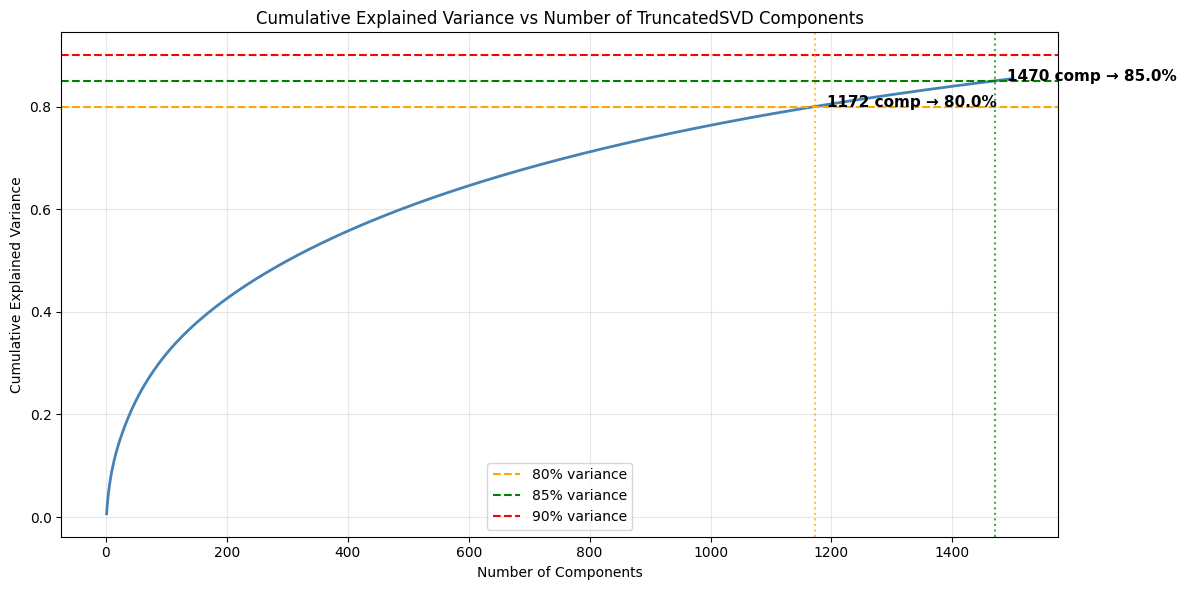

In [12]:
max_components = min(3000, X_train_tfidf.shape[1] - 1)

svd_full = TruncatedSVD(n_components=max_components, random_state=42)
svd_full.fit(X_train_tfidf)

cumulative_variance = np.cumsum(svd_full.explained_variance_ratio_)

# Find the smallest n where variance >= target
targets = [0.80, 0.85, 0.90]
optimal_ns = {}

for target in targets:
    n = np.argmax(cumulative_variance >= target) + 1
    optimal_ns[target] = n
    print(f"Components needed for >={target*100:.0f}% variance: {n} (actual: {cumulative_variance[n-1]:.4f})")

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_variance[:1500])+1), cumulative_variance[:1500],
         color='steelblue', linewidth=2)
plt.axhline(y=0.80, color='orange', linestyle='--', label='80% variance')
plt.axhline(y=0.85, color='green', linestyle='--', label='85% variance')
plt.axhline(y=0.90, color='red', linestyle='--', label='90% variance')

for target, n in optimal_ns.items():
    if n <= 1500:
        plt.axvline(x=n, color={0.80:'orange', 0.85:'green', 0.90:'red'}[target],
                    linestyle=':', alpha=0.7)
        plt.text(n+20, target, f'{n} comp → {target*100}%', fontsize=11, fontweight='bold')

plt.title("Cumulative Explained Variance vs Number of TruncatedSVD Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
n_components = min(X_train_tfidf.shape[0]-1, X_train_tfidf.shape[1]-1, 1470)

svd = TruncatedSVD(n_components=n_components, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd = svd.transform(X_val_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

print(f"TruncatedSVD shape (train): {X_train_svd.shape}")
print(f"TruncatedSVD shape (val): {X_val_svd.shape}")
print(f"TruncatedSVD shape (test): {X_test_svd.shape}")

TruncatedSVD shape (train): (5427, 1470)
TruncatedSVD shape (val): (677, 1470)
TruncatedSVD shape (test): (678, 1470)


## **2D Visualization of Class Separability**

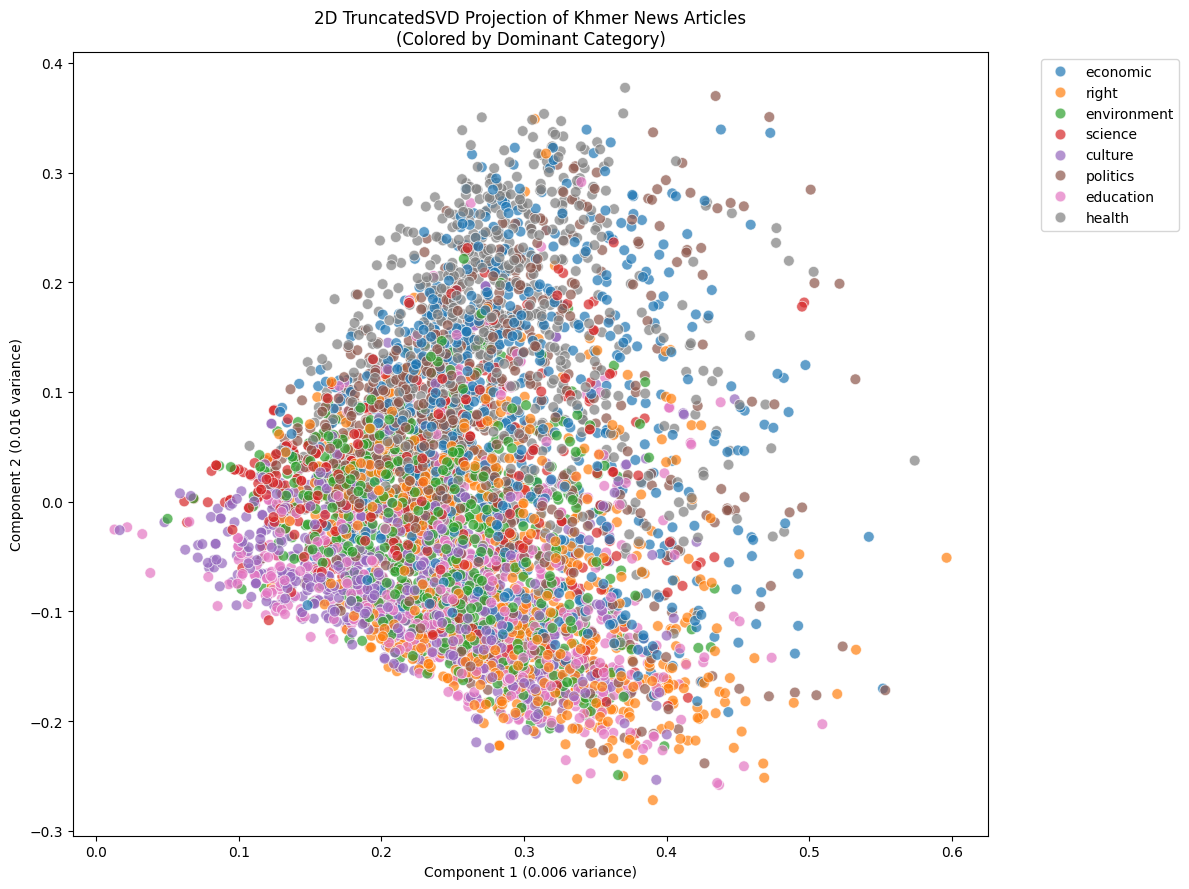

In [14]:
svd_2d = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd_2d.fit_transform(X_train_tfidf)

dominant_idx = np.argmax(y_train, axis=1)
dominant_labels = [label_cols[i] for i in dominant_idx]

plt.figure(figsize=(12, 9))
sns.scatterplot(
    x=X_2d[:, 0], y=X_2d[:, 1],
    hue=dominant_labels,
    palette='tab10',
    alpha=0.7,
    s=60
)
plt.title("2D TruncatedSVD Projection of Khmer News Articles\n(Colored by Dominant Category)")
plt.xlabel(f"Component 1 ({svd_2d.explained_variance_ratio_[0]:.3f} variance)")
plt.ylabel(f"Component 2 ({svd_2d.explained_variance_ratio_[1]:.3f} variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## **3D Visualization of Class Separability**

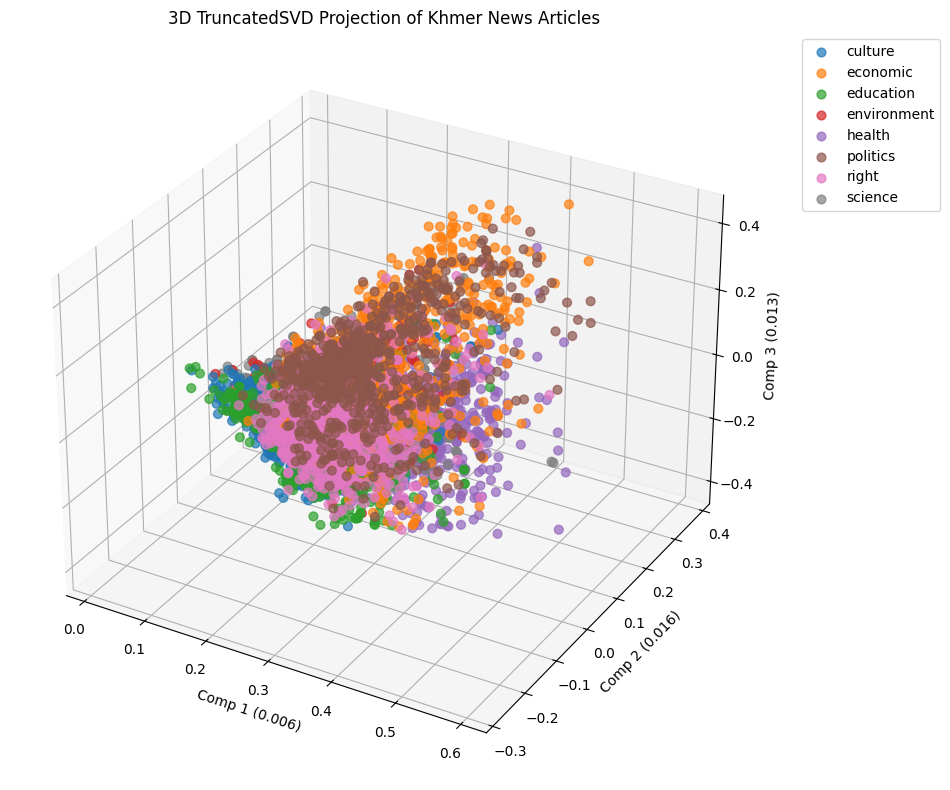

In [15]:
# 1. Run TruncatedSVD with 3 components
svd_3d = TruncatedSVD(n_components=3, random_state=42)
X_3d = svd_3d.fit_transform(X_train_tfidf)

# 2. Prepare labels (using your existing logic)
# Assuming y_train is a numpy array or compatible structure
dominant_idx = np.argmax(y_train, axis=1) 
dominant_labels = np.array([label_cols[i] for i in dominant_idx])

# 3. Create 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Iterate through unique labels to plot them with correct colors and legend
unique_labels = sorted(list(set(dominant_labels)))

for label in unique_labels:
    # Create a mask for the current label
    mask = (dominant_labels == label)
    
    ax.scatter(
        X_3d[mask, 0],  # Component 1
        X_3d[mask, 1],  # Component 2
        X_3d[mask, 2],  # Component 3
        label=label,
        s=40,           # Size of dots
        alpha=0.7       # Transparency
    )

# 4. Set labels and title
ax.set_title("3D TruncatedSVD Projection of Khmer News Articles")
ax.set_xlabel(f"Comp 1 ({svd_3d.explained_variance_ratio_[0]:.3f})")
ax.set_ylabel(f"Comp 2 ({svd_3d.explained_variance_ratio_[1]:.3f})")
ax.set_zlabel(f"Comp 3 ({svd_3d.explained_variance_ratio_[2]:.3f})")

# Place legend outside to avoid clutter
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# **Train Classifiers with Class Imbalance Handling**

In [16]:
classifiers = {
    "Logistic Regression": OneVsRestClassifier(
        LogisticRegression(
            C=1.0,               # Moderate regularization; try 0.1 if overfitting
            class_weight='balanced', 
            solver='liblinear',  # Usually better for high-dimensional sparse data
            max_iter=1000, 
            random_state=42
        )
    ),
    "Linear SVM": OneVsRestClassifier(
        LinearSVC(
            C=0.1,               # Lower C = stronger regularization (prevents overfitting)
            class_weight='balanced', 
            dual=False,          # Set to False when n_samples > n_features
            random_state=42
        )
    ),
    "Random Forest": OneVsRestClassifier(
        RandomForestClassifier(
            n_estimators=500,    # More trees = more stability
            max_depth=30,        # Limit depth to prevent "memorizing" specific articles
            min_samples_leaf=2,  # Prevents creating nodes for just 1 outlier sample
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
    ),
    "XGBoost": OneVsRestClassifier(
        XGBClassifier(
            n_estimators=1000,
            learning_rate=0.05,  # Slow and steady learning is better for text
            max_depth=6,         # Standard for text; prevents deep tree overfitting
            subsample=0.8,       # Only use 80% of data for each tree (adds robustness)
            colsample_bytree=0.8,# Only use 80% of features for each tree
            scale_pos_weight=5,  # Keep this since your categories are likely sparse
            eval_metric='logloss',
            random_state=42,
            n_jobs=-1
        )
    ),
    "LightGBM": OneVsRestClassifier(
        LGBMClassifier(
            n_estimators=1000,
            learning_rate=0.05,
            num_leaves=31,       # Standard leaf-wise growth limit
            feature_fraction=0.8, # Similar to colsample_bytree in XGB
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            importance_type='gain'
        )
    )
}

In [17]:
results = {}

print("Training and evaluating models...\n")
for name, clf in classifiers.items():
    print(f"→ Training {name}...")
    clf.fit(X_train_svd, y_train)

    y_pred = clf.predict(X_val_svd)

    macro_f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
    results[name] = macro_f1

    print(f"{name} — Validation Macro F1: {macro_f1:.4f}")
    print(classification_report(y_val, y_pred, target_names=label_cols, zero_division=0))
    print("-" * 60)

Training and evaluating models...

→ Training Logistic Regression...
Logistic Regression — Validation Macro F1: 0.7494
              precision    recall  f1-score   support

     culture       0.64      0.88      0.74        88
    economic       0.61      0.79      0.69        87
   education       0.67      0.91      0.77        88
 environment       0.80      0.89      0.84        93
      health       0.75      0.92      0.83        87
    politics       0.59      0.90      0.71        87
       right       0.57      0.84      0.68        93
     science       0.62      0.93      0.75        54

   micro avg       0.65      0.88      0.75       677
   macro avg       0.65      0.88      0.75       677
weighted avg       0.66      0.88      0.75       677
 samples avg       0.71      0.88      0.77       677

------------------------------------------------------------
→ Training Linear SVM...
Linear SVM — Validation Macro F1: 0.7486
              precision    recall  f1-score   sup

## **Confusion Matrices Per Category**

Plotting confusion matrices using: XGBoost


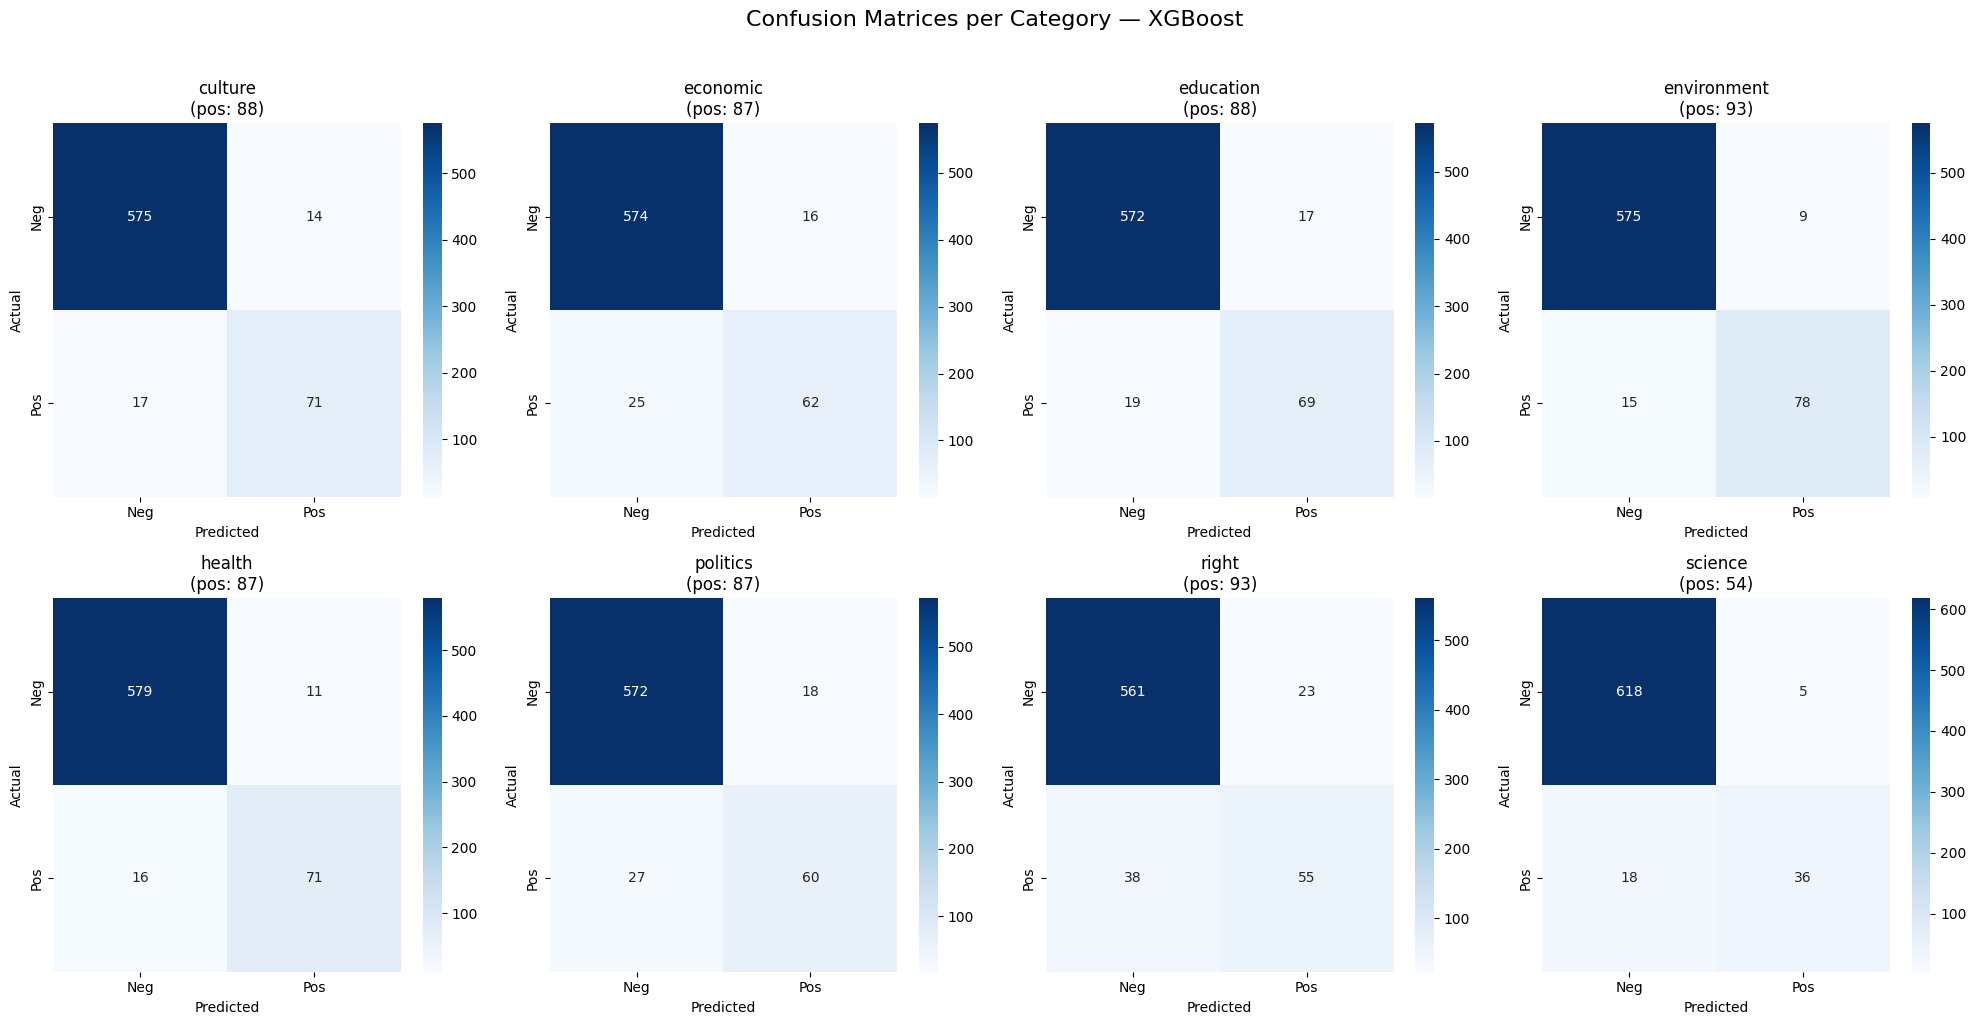

In [20]:
best_model_name = max(results, key=results.get)
best_clf = classifiers[best_model_name]
y_pred_best = best_clf.predict(X_val_svd)

print(f"Plotting confusion matrices using: {best_model_name}")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, label in enumerate(label_cols):
    cm = confusion_matrix(y_val.iloc[:, i], y_pred_best[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                ax=axes[i],
                xticklabels=['Neg', 'Pos'],
                yticklabels=['Neg', 'Pos'])
    axes[i].set_title(f"{label}\n(pos: {y_val.iloc[:, i].sum()})")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.suptitle(f"Confusion Matrices per Category — {best_model_name}", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


STEP 1: TEST SET EVALUATION - XGBoost

Test Macro F1: 0.7755

              precision    recall  f1-score   support

     culture       0.80      0.81      0.80        89
    economic       0.81      0.63      0.71        86
   education       0.82      0.80      0.81        89
 environment       0.89      0.91      0.90        94
      health       0.83      0.86      0.84        88
    politics       0.80      0.61      0.69        87
       right       0.78      0.65      0.71        92
     science       0.87      0.64      0.74        53

   micro avg       0.82      0.75      0.78       678
   macro avg       0.82      0.74      0.78       678
weighted avg       0.82      0.75      0.78       678
 samples avg       0.73      0.75      0.74       678


Test Set Confusion Matrices per Category


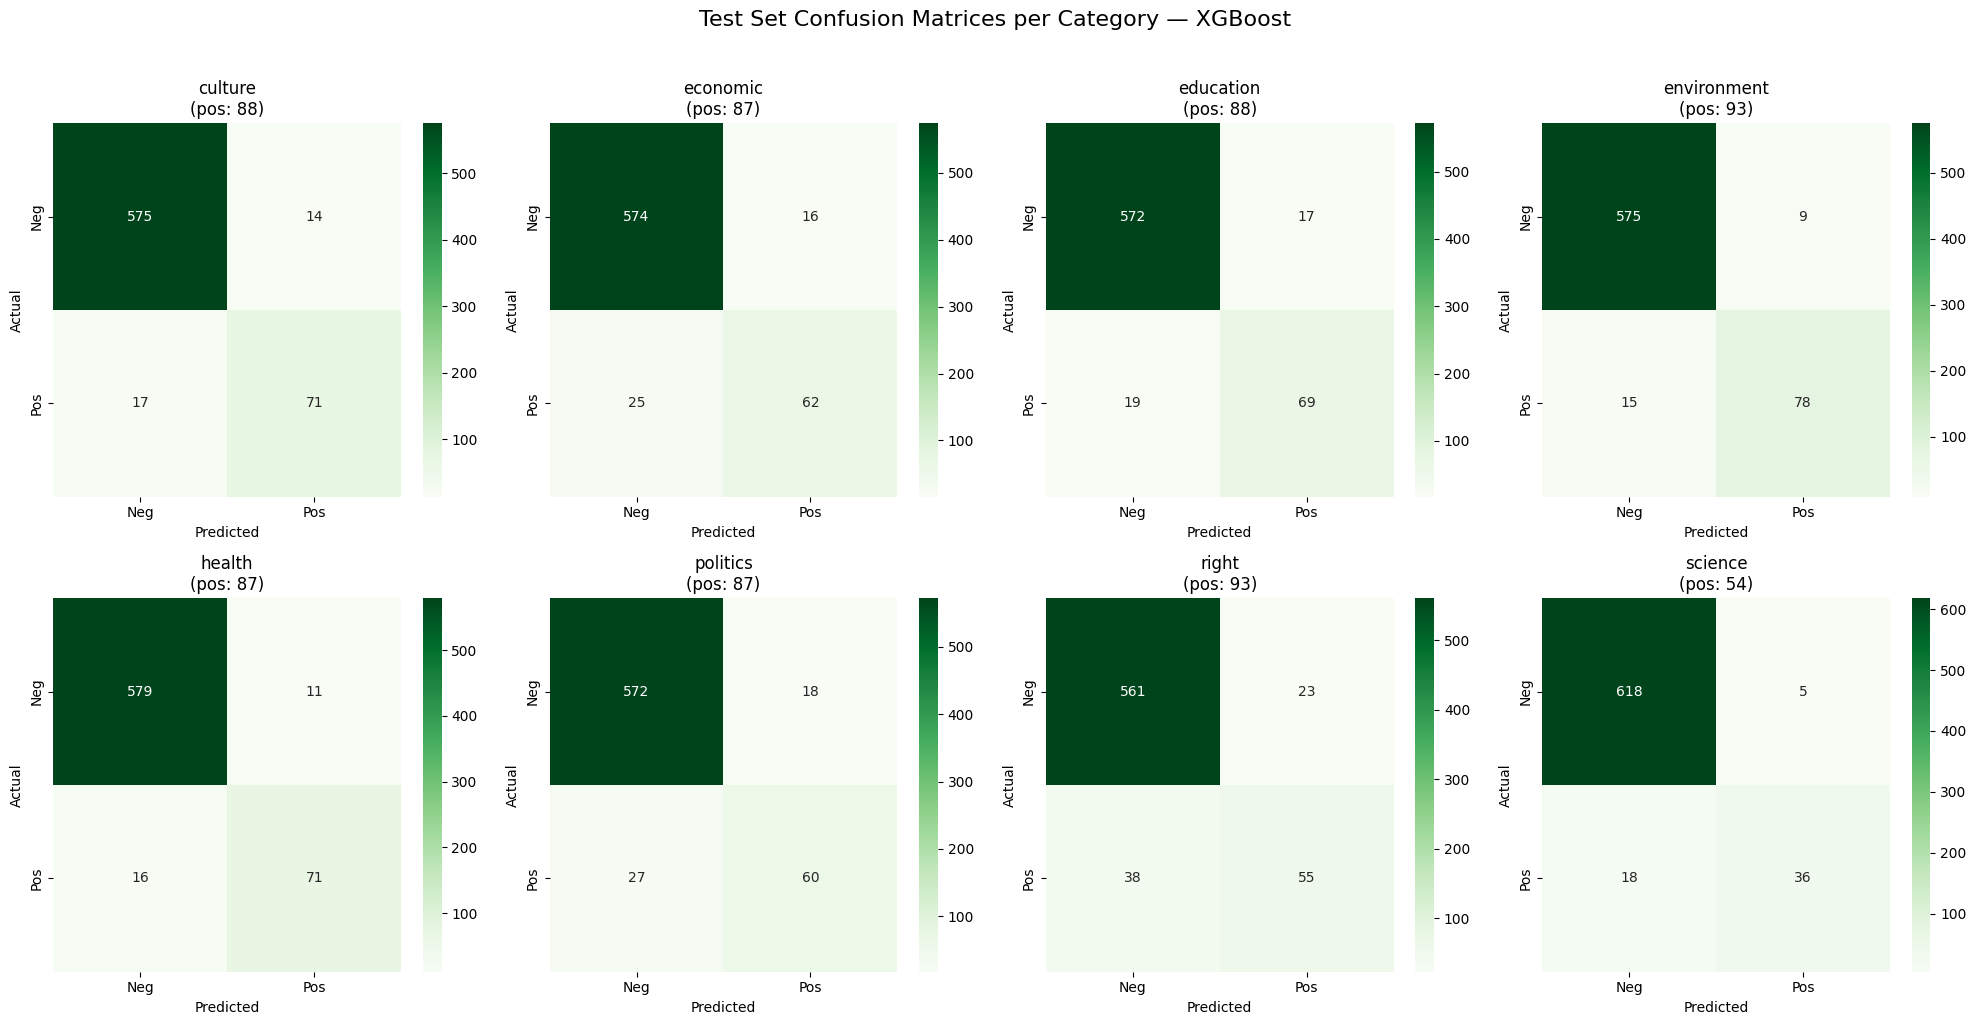

In [21]:
# Step 1: Evaluate best model on TEST set
print("\n" + "="*80)
print(f"STEP 1: TEST SET EVALUATION - {best_model_name}")
print("="*80)

y_pred_test = best_clf.predict(X_test_svd)
test_macro_f1 = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

print(f"\nTest Macro F1: {test_macro_f1:.4f}")
print("\n" + classification_report(y_test, y_pred_test, target_names=label_cols, zero_division=0))

# Confusion matrices for test set
print("\n" + "="*80)
print("Test Set Confusion Matrices per Category")
print("="*80)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, label in enumerate(label_cols):
    cm = confusion_matrix(y_val.iloc[:, i], y_pred_best[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                ax=axes[i],
                xticklabels=['Neg', 'Pos'],
                yticklabels=['Neg', 'Pos'])
    axes[i].set_title(f"{label}\n(pos: {y_val.iloc[:, i].sum()})")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.suptitle(f"Test Set Confusion Matrices per Category — {best_model_name}", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()



STEP 2: COMPARING METRICS ACROSS TRAIN, VAL, TEST SETS

Performance Summary Across All Splits:
   Dataset  Macro F1  Samples
  Training  0.997201     5427
Validation  0.775097      677
      Test  0.775517      678


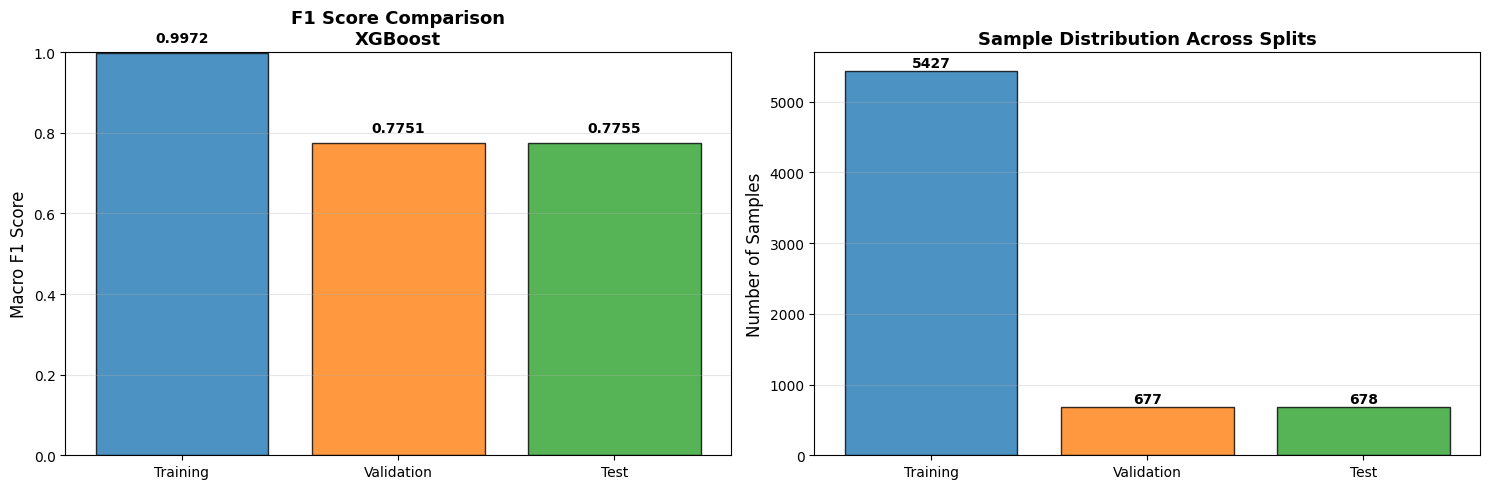


--------------------------------------------------------------------------------
Overfitting Analysis:
--------------------------------------------------------------------------------
Train → Val F1 drop: 22.27%
Train → Test F1 drop: 22.23%
⚠ Potential overfitting: Significant gap between training and test performance


In [22]:
# Step 2: Compare metrics across TRAIN, VAL, and TEST sets
print("\n" + "="*80)
print("STEP 2: COMPARING METRICS ACROSS TRAIN, VAL, TEST SETS")
print("="*80)

# Get predictions for all sets
y_pred_train = best_clf.predict(X_train_svd)

# Calculate F1 scores for all three sets
train_macro_f1 = f1_score(y_train, y_pred_train, average='macro', zero_division=0)
val_macro_f1 = f1_score(y_val, y_pred_best, average='macro', zero_division=0)  # Already calculated
# test_macro_f1 already calculated above

# Create comparison table
comparison_data = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'Macro F1': [train_macro_f1, val_macro_f1, test_macro_f1],
    'Samples': [len(y_train), len(y_val), len(y_test)]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nPerformance Summary Across All Splits:")
print(comparison_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: F1 Score Comparison
axes[0].bar(comparison_df['Dataset'], comparison_df['Macro F1'], 
            color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Macro F1 Score', fontsize=12)
axes[0].set_title(f'F1 Score Comparison\n{best_model_name}', fontsize=13, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)

# Annotate bars
for i, (dataset, f1) in enumerate(zip(comparison_df['Dataset'], comparison_df['Macro F1'])):
    axes[0].text(i, f1 + 0.02, f'{f1:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Sample Distribution
axes[1].bar(comparison_df['Dataset'], comparison_df['Samples'],
            color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8, edgecolor='black')
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].set_title('Sample Distribution Across Splits', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Annotate bars
for i, (dataset, count) in enumerate(zip(comparison_df['Dataset'], comparison_df['Samples'])):
    axes[1].text(i, count + 20, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Detect overfitting
print("\n" + "-"*80)
print("Overfitting Analysis:")
print("-"*80)
f1_drop_val = (train_macro_f1 - val_macro_f1) / train_macro_f1 * 100 if train_macro_f1 > 0 else 0
f1_drop_test = (train_macro_f1 - test_macro_f1) / train_macro_f1 * 100 if train_macro_f1 > 0 else 0

print(f"Train → Val F1 drop: {f1_drop_val:.2f}%")
print(f"Train → Test F1 drop: {f1_drop_test:.2f}%")

if f1_drop_test < 5:
    print("✓ Excellent generalization: Test performance is close to training")
elif f1_drop_test < 15:
    print("✓ Good generalization: Reasonable gap between training and test")
else:
    print("⚠ Potential overfitting: Significant gap between training and test performance")


# **Saving and Loading Each Model**

In [23]:
# Save each classifier (including the OneVsRest wrapper)
dump(classifiers["Logistic Regression"], '../models/tfidf_models_with_truncatedSVD/logistic_regression_model.joblib')
dump(classifiers["Linear SVM"], '../models/tfidf_models_with_truncatedSVD/linear_svm_model.joblib')
dump(classifiers["Random Forest"], '../models/tfidf_models_with_truncatedSVD/random_forest_model.joblib')
dump(classifiers["XGBoost"], '../models/tfidf_models_with_truncatedSVD/xgboost_model.joblib')
dump(classifiers["LightGBM"], '../models/tfidf_models_with_truncatedSVD/lightgbm_model.joblib')

# Also save the preprocessing objects (critical for inference!)
dump(tfidf, '../models/tfidf_models_with_truncatedSVD/tfidf_vectorizer.joblib')
dump(svd, '../models/tfidf_models_with_truncatedSVD/truncated_svd.joblib')

print("Models and preprocessors saved successfully!")

Models and preprocessors saved successfully!


In [27]:
# Load everything
tfidf_loaded = load('../models/tfidf_models_with_truncatedSVD/tfidf_vectorizer.joblib')
svd_loaded   = load('../models/tfidf_models_with_truncatedSVD/truncated_svd.joblib')
ligthtgbm_loaded = load('../models/tfidf_models_with_truncatedSVD/lightgbm_model.joblib')

## **Test on new data**

In [28]:
# Preprocess new text exactly like training
new_texts = ["រាជធានីភ្នំពេញ​៖ OCIC គឺជា​សម្ព័ន្ធ​សហគ្រាស និង​ជា​ក្រុមហ៊ុន​អភិវឌ្ឍន៍​អចលនទ្រព្យ​ ឈានមុខ​នៅ​ប្រទេស​កម្ពុជា និង ezesoft ផ្គត់ផ្គង់ និង​ដោះស្រាយ​សេវា​ឌី​ជី​ថ​ល​នៅ​កម្ពុជា ដែល​ជា​ផ្នែក​មួយ​នៃ​រចនាសម្ព័ន្ធ ឌី​ជី​ថ​ល ទំនាក់ទំនង និង​បច្ចេកវិទ្យា (DCT) របស់​ក្រុមហ៊ុន រ៉ូ​យ៉ា​ល់ គ្រុប បាន​ប្រកាស​ពី​ដៃគូ​យុទ្ធសាស្ត្រ ដើម្បី​ដាក់​ឱ្យ​ប្រើប្រាស់ WiFiX ដែល​ជា​សេវា WiFi សាធារណៈ​នៅ​ទីក្រុង​ន​រា ដោយ​ផ្ដល់​ជូន​ការ​ប្រើប្រាស់​អ៊ីនធឺណិត​ ដោយ​ឥត​គិតថ្លៃ មាន​សុវត្ថិភាព និង​ដំណើរការ​ពេញ 24 ម៉ោង ​។ កិច្ចព្រមព្រៀង​នេះ​ត្រូវ​បាន​ចុះហត្ថលេខា​ ដោយ​លោក Luis Chen អនុប្រធាន​ប្រតិបត្តិ​នៃ​ក្រុមហ៊ុន OCIC និង​លោក Yap Kok Leong អគ្គនាយក​ប្រតិបត្តិ​រចនាសម្ព័ន្ធ DCT របស់​ក្រុមហ៊ុន រ៉ូ​យ៉ា​ល់ គ្រុប និង​ក្រុមហ៊ុន ezesoft​ ។",
             "យោង​តាម​ការ​ផ្សាយ​របស់​មន្ទីរពេទ្យ​កាល់​ម៉ែ​ត បាន​លើក​ឡើង​ពី​ភាព​ចាំបាច់​ក្នុង​ការ​ស្វែង​យល់​អំពី​រោគ​សញ្ញា​នៃ ជំងឺ​រលាក​លំពែង​ស្រួច​ស្រាវ ដែល​ជា​ជំងឺ​មួយ​អាច​បង្ក​គ្រោះថ្នាក់​ធ្ងន់ធ្ងរ​ដល់​អាយុជីវិត ប្រសិនបើ​មិន​បាន​ទទួល​ការ​ព្យាបាល​ទាន់​ពេលវេលា​។ជំងឺ​រលាក​លំពែង​ស្រួច​ស្រាវ គឺជា​ការ​រលាក​ភ្លាម​ៗ​នៃ​ក្រពេញ​លំពែង ដែល​បង្ក​ឱ្យ​មានការ​ឈឺចាប់​ខ្លាំង​។ ដូច្នេះ ប្រសិនបើ​មាន​រោគ​សញ្ញា​ណាមួយ​ខាងក្រោម​នេះ សូម​ប្រញាប់​ទៅ​ពិគ្រោះ​ជាមួយ​គ្រូពេទ្យ​ជា​បន្ទាន់​៖រោគ​សញ្ញា​ប្រុង​ប្រយ័ត្ន​នៃ​ជំងឺ​រលាក​លំពែង​ស្រួច​ស្រាវ​៖ឈឺ​ចុកចាប់​ក្នុង​ពោះ​ខ្លាំងក្លា​ភ្លាម​ៗ: ជា​ពិសេស​នៅ​តំបន់​ចុងដង្ហើម ហើយ​អាច​រាលដាល​ដល់​ខ្នង (​រោគ​សញ្ញា​សំខាន់​)​។ក្អួតចង្អោរ​: ជា​រឿយ​ៗ​អម​ដោយ​អាកា​រៈ​ឈឺពោះ​។ការ​ទល់ខ្យល់ និង​លាមក​: បង្ហាញ​ពី​បញ្ហា​ក្នុង​ប្រព័ន្ធ​រំលាយ​អាហារ​។គ្រុនក្តៅ (​ឡើងក​ម្តៅ​ខ្លួន​): ជា​សញ្ញា​នៃ​ការ​រលាក​ឬ​ឆ្លង​មេរោគ​ក្នុង​រាង​កាយ​។ហត់​ដង្ហក់​ពិបាក​ដកដង្ហើម​: អាច​កើតឡើង​ក្នុង​ករណី​ធ្ងន់ធ្ងរ​។ដំបូន្មាន​សំខាន់​: ការ​ឈឺចាប់​ខ្លាំង​នៅ​ពោះ​ផ្នែក​ខាងលើ គឺជា​សញ្ញា​ដាស់តឿន​ដ៏​ធំ​។ កុំ​ធ្វេសប្រហែស​! ការ​ស្វែងរក​ការ​ពិនិត្យ​និង​ព្យាបាល​ទាន់​ពេលវេលា​ពី​គ្រូពេទ្យ​ឯកទេស គឺជា​គន្លឹះ​ដើម្បី​ជួយ​សង្គ្រោះ​ជីវិត​អ្នកជំងឺ​៕"]

In [29]:
# Preprocess exactly like training
new_tokenized = [khmer_tokenize(text) for text in new_texts]

X_new_tfidf = tfidf_loaded.transform(new_tokenized)
X_new_reduced = svd_loaded.transform(X_new_tfidf)

# Get probabilities (shape: [n_articles, n_classes])
binary_predictions = ligthtgbm_loaded.predict(X_new_reduced)
probabilities = ligthtgbm_loaded.predict_proba(X_new_reduced)

# Article titles for plot
article_titles = [
    "OCIC and ezesoft Partner to Launch Free Public WiFi Service in Angkor",
    "Recognizing Symptoms of Acute Appendicitis"
]

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGB

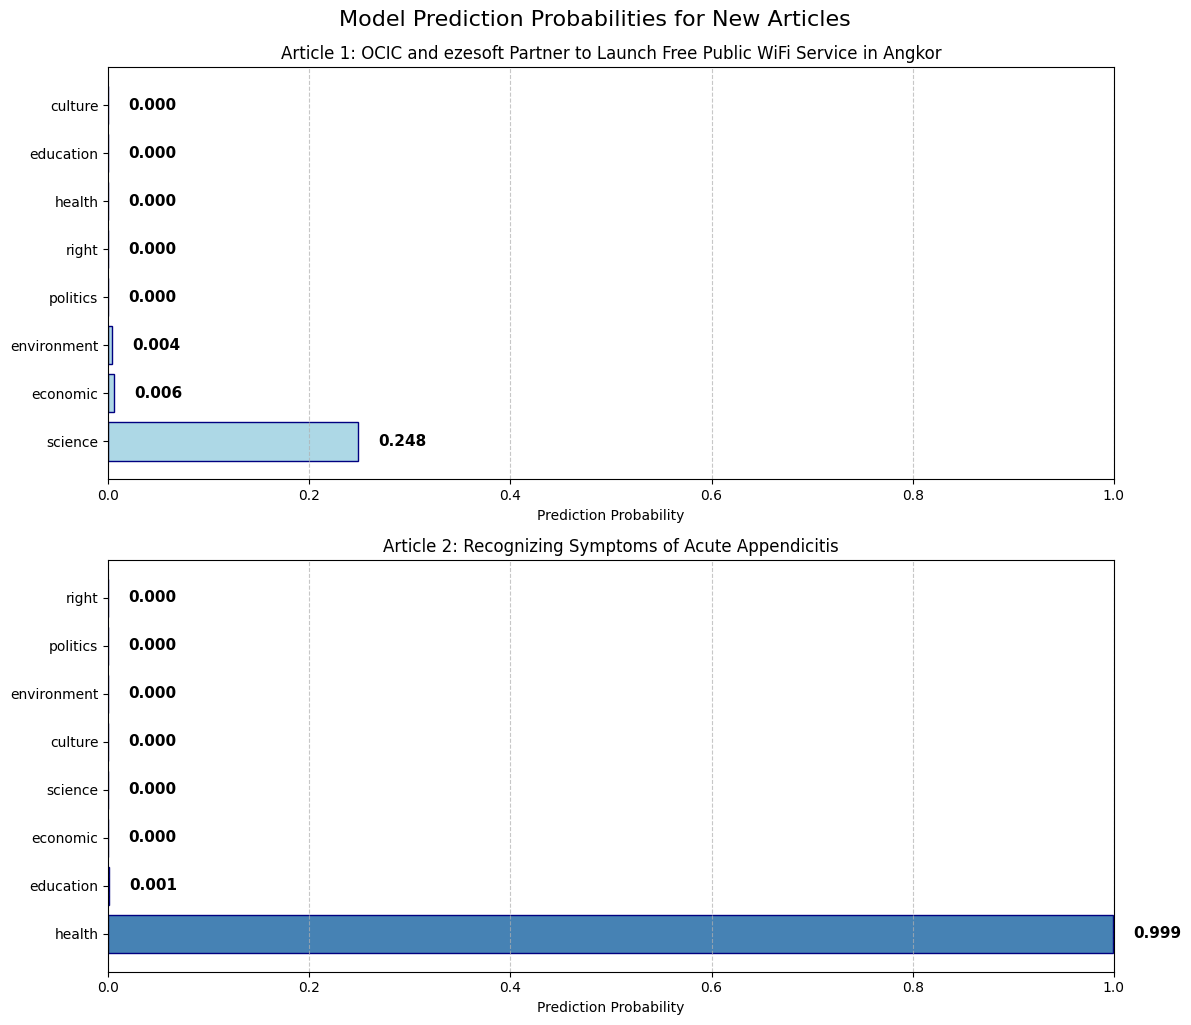

In [30]:
# Plot bar charts
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

for idx, (probs, ax, title) in enumerate(zip(probabilities, axes, article_titles)):
    # Sort categories by probability (descending)
    sorted_idx = np.argsort(probs)[::-1]
    sorted_labels = [label_cols[i] for i in sorted_idx]
    sorted_probs = probs[sorted_idx]

    # Colors: highlight high confidence (>0.5)
    colors = ['steelblue' if p > 0.5 else 'lightblue' for p in sorted_probs]

    bars = ax.barh(sorted_labels, sorted_probs, color=colors, edgecolor='navy')
    ax.set_xlim(0, 1)
    ax.set_xlabel('Prediction Probability')
    ax.set_title(f"Article {idx+1}: {title}")
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Annotate values on bars
    for bar, p in zip(bars, sorted_probs):
        ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                f'{p:.3f}', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.suptitle("Model Prediction Probabilities for New Articles", fontsize=16, y=1.02)
plt.show()